# Stat 958:587 - Homework 3
**Due: 11/25/2025**

This notebook contains four problems covering Bayesian hierarchical modeling, Gibbs sampling, stochastic differential equations, and Monte Carlo methods.

## Problem 1: Bayesian Hierarchical Model for Power Plant Pump Failures

The following table gives for ten power plant pumps the recorded number of failures $Y_i$ and the length $t_i$ of operation time (in 1000s of hours):

| Pump $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|--------|
| $t_i$ | 94.3 | 15.7 | 62.9 | 126 | 5.24 | 31.4 | 1.05 | 1.05 | 2.1 | 10.5 |
| $Y_i$ | 5 | 1 | 5 | 14 | 3 | 19 | 1 | 1 | 4 | 22 |

The number of failures is assumed to follow a Poisson distribution:

$$Y_i \sim \text{Poisson}(\theta_i t_i), \quad i = 1, \ldots, 10$$

where $\theta_i$ is the failure rate for pump $i$. For Bayesian inference we adopt a conjugate gamma prior distribution for the failure rates:

$$\theta_i \sim \Gamma(\alpha, \beta), \quad i = 1, \ldots, 10$$

Instead of specifying particular values for both hyperparameters $\alpha$ and $\beta$, we assume the following hierarchical prior specification:

$$\alpha = 1$$
$$\beta \sim \Gamma(1/5, 1)$$

### Part (a): Compute the full conditional posterior distributions

Compute the full conditional posterior distributions for $\theta_i$ and $\beta$. 

**Hint:** Use the trick of "$\propto$" in calculating Bayesian posteriors.

**Your answer:**

# Part (a): Full Conditional Posterior Distributions

## Given Model

- $Y_i \mid \theta_i \sim \text{Poisson}(\theta_i t_i)$
- $\theta_i \mid \beta \sim \Gamma(\alpha, \beta)$ with $\alpha = 1$
- $\beta \sim \Gamma\left(\frac{1}{5}, 1\right)$

---

## Derivation of Full Conditional for $\theta_i \mid \beta, Y$

Using the proportionality trick:

$$p(\theta_i \mid \beta, Y_i) \propto p(Y_i \mid \theta_i) \cdot p(\theta_i \mid \beta)$$

$$\propto \left[ e^{-\theta_i t_i} (\theta_i t_i)^{Y_i} \right] \cdot \left[ \beta^\alpha \theta_i^{\alpha - 1} e^{-\beta \theta_i} \right]$$

$$\propto e^{-\theta_i t_i} \cdot \theta_i^{Y_i} \cdot \theta_i^{1-1} \cdot e^{-\beta \theta_i}$$

$$\propto \theta_i^{Y_i} \cdot e^{-(t_i + \beta)\theta_i}$$

This is the kernel of a Gamma distribution.

$$\boxed{\theta_i \mid \beta, Y_i \sim \Gamma(Y_i + 1, \, t_i + \beta)}$$

---

## Derivation of Full Conditional for $\beta \mid \boldsymbol{\theta}, Y$

$$p(\beta \mid \boldsymbol{\theta}, Y) \propto p(\boldsymbol{\theta} \mid \beta) \cdot p(\beta)$$

$$\propto \left[ \prod_{i=1}^{10} \beta^\alpha \theta_i^{\alpha-1} e^{-\beta \theta_i} \right] \cdot \left[ \beta^{1/5 - 1} e^{-\beta} \right]$$

$$\propto \beta^{n\alpha} \cdot e^{-\beta \sum_{i=1}^{10} \theta_i} \cdot \beta^{1/5 - 1} \cdot e^{-\beta}$$

With $n = 10$ and $\alpha = 1$:

$$\propto \beta^{10} \cdot e^{-\beta \sum \theta_i} \cdot \beta^{-4/5} \cdot e^{-\beta}$$

$$\propto \beta^{10 - 4/5} \cdot e^{-\beta(1 + \sum \theta_i)}$$

$$\propto \beta^{46/5} \cdot e^{-\beta(1 + \sum \theta_i)}$$

This is the kernel of a Gamma distribution.

$$\boxed{\beta \mid \boldsymbol{\theta} \sim \Gamma\left(\frac{51}{5}, \, 1 + \sum_{i=1}^{10} \theta_i\right)}$$

---

## Summary of Full Conditional Distributions

| Parameter | Full Conditional Distribution |
|-----------|-------------------------------|
| $\theta_i$ | $\Gamma\left(Y_i + 1, \, t_i + \beta\right)$ |
| $\beta$ | $\Gamma\left(\frac{51}{5}, \, 1 + \sum_{i=1}^{10} \theta_i\right)$ |

**Note:** The Gamma distribution is parameterized as $\Gamma(\text{shape}, \text{rate})$.



### Part (b): Formulate the Gibbs sampler

Based on the results from part (a), formulate the Gibbs sampler for this problem.

**Your answer:**

# Part (b): Gibbs Sampler Algorithm

## Overview

The Gibbs sampler is an MCMC algorithm that alternately samples from the full conditional distributions derived in Part (a). For this hierarchical model, we iteratively sample from:

- $\theta_i \mid \beta, Y_i \sim \Gamma(Y_i + 1, \, t_i + \beta)$
- $\beta \mid \boldsymbol{\theta} \sim \Gamma\left(\frac{51}{5}, \, 1 + \sum_{i=1}^{10} \theta_i\right)$

---

## Gibbs Sampling Algorithm

### Algorithm Steps

**Initialization:**
1. Set $\beta^{(0)}$ (e.g., $\beta^{(0)} = 1$)
2. Initialize $\theta_i^{(0)}$ for $i = 1, \ldots, 10$ (e.g., $\theta_i^{(0)} = Y_i / t_i$)

**For each iteration $m = 1, 2, \ldots, M$:**

**Step 1: Update $\theta_i$ for each pump**

For $i = 1, 2, \ldots, 10$:
$$\theta_i^{(m)} \sim \Gamma\left(Y_i + 1, \, t_i + \beta^{(m-1)}\right)$$

**Step 2: Update $\beta$**

$$\beta^{(m)} \sim \Gamma\left(\frac{51}{5}, \, 1 + \sum_{i=1}^{10} \theta_i^{(m)}\right)$$

---

## Pseudocode

```
Algorithm: Gibbs Sampler

Input: Y, t, M (number of iterations), B (burn-in)

Initialize:
  beta[0] = 1.0
  theta[0, :] = Y / t

For m = 1 to M:
    For i = 1 to 10:
        shape = Y[i] + 1
        rate = t[i] + beta[m-1]
        theta[m, i] ~ Gamma(shape, rate)
    
    shape_beta = 51/5
    rate_beta = 1 + sum(theta[m, :])
    beta[m] ~ Gamma(shape_beta, rate_beta)

Return: theta[B+1:M], beta[B+1:M]
```

---

## Convergence Recommendations

- **Burn-in:** Remove first 1,000 iterations
- **Total iterations:** Run 10,000-50,000 iterations
- **Check trace plots** for convergence and mixing
- **Plot autocorrelation** to assess correlation between samples


### Part (c): Implement the Gibbs sampler and plot marginal posteriors

Implement the Gibbs sampler and apply it to the pump data. Plot the marginal posterior densities of $\beta$, $\theta_1$ and $\theta_6$. 

**Required:** 3 plots

**Your solution:**

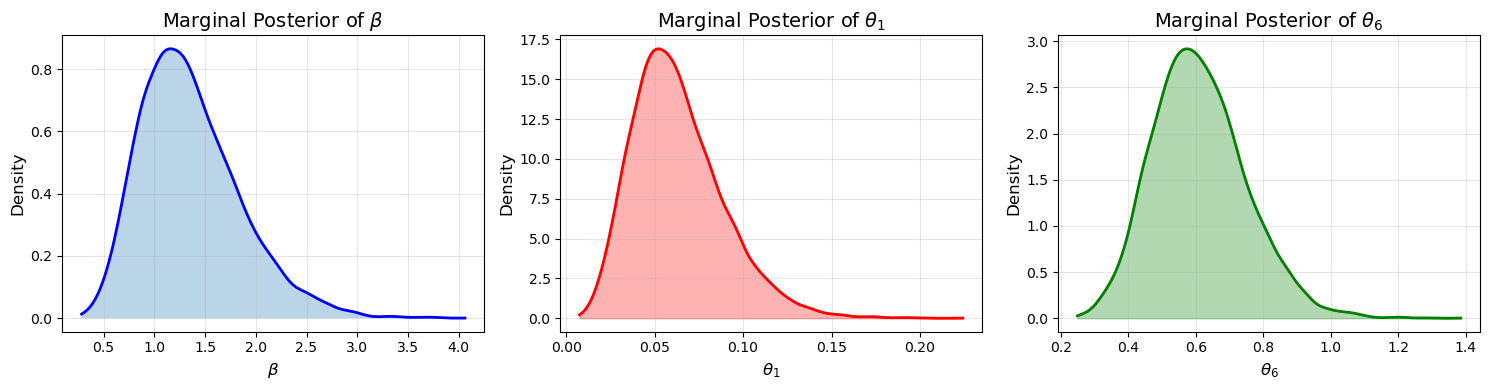

beta:    Mean = 1.3582, Std = 0.4940
theta_1: Mean = 0.0631, Std = 0.0256
theta_6: Mean = 0.6112, Std = 0.1382


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Set random seed for reproducibility
np.random.seed(42)

# Pump data
t = np.array([94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5])
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])

# Hyperparameters
alpha = 1
n_pumps = 10

# Gibbs sampler parameters
M = 10000  # Total iterations
burn_in = 1000  # Burn-in period

# Storage for samples
beta_samples = np.zeros(M)
theta_samples = np.zeros((M, n_pumps))

# Initialize
beta_samples[0] = 1.0
theta_samples[0, :] = y / t  # MLE initialization

# Gibbs sampler
for m in range(1, M):
    # Step 1: Sample theta_i from Gamma(Y_i + 1, t_i + beta)
    for i in range(n_pumps):
        shape_theta = y[i] + alpha
        rate_theta = t[i] + beta_samples[m-1]
        theta_samples[m, i] = np.random.gamma(shape_theta, 1/rate_theta)
    
    # Step 2: Sample beta from Gamma(51/5, 1 + sum(theta))
    shape_beta = alpha + n_pumps * alpha - 1 + 1/5  # = 51/5
    rate_beta = 1 + np.sum(theta_samples[m, :])
    beta_samples[m] = np.random.gamma(shape_beta, 1/rate_beta)

# Remove burn-in
beta_post = beta_samples[burn_in:]
theta1_post = theta_samples[burn_in:, 0]  # theta_1
theta6_post = theta_samples[burn_in:, 5]  # theta_6 (index 5)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Marginal posterior of beta
ax1 = axes[0]
kde_beta = gaussian_kde(beta_post)
x_beta = np.linspace(beta_post.min(), beta_post.max(), 200)
ax1.plot(x_beta, kde_beta(x_beta), 'b-', linewidth=2)
ax1.fill_between(x_beta, kde_beta(x_beta), alpha=0.3)
ax1.set_xlabel(r'$\beta$', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title(r'Marginal Posterior of $\beta$', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Marginal posterior of theta_1
ax2 = axes[1]
kde_theta1 = gaussian_kde(theta1_post)
x_theta1 = np.linspace(theta1_post.min(), theta1_post.max(), 200)
ax2.plot(x_theta1, kde_theta1(x_theta1), 'r-', linewidth=2)
ax2.fill_between(x_theta1, kde_theta1(x_theta1), alpha=0.3, color='red')
ax2.set_xlabel(r'$\theta_1$', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title(r'Marginal Posterior of $\theta_1$', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Marginal posterior of theta_6
ax3 = axes[2]
kde_theta6 = gaussian_kde(theta6_post)
x_theta6 = np.linspace(theta6_post.min(), theta6_post.max(), 200)
ax3.plot(x_theta6, kde_theta6(x_theta6), 'g-', linewidth=2)
ax3.fill_between(x_theta6, kde_theta6(x_theta6), alpha=0.3, color='green')
ax3.set_xlabel(r'$\theta_6$', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title(r'Marginal Posterior of $\theta_6$', fontsize=14)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem1c_posteriors.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"beta:    Mean = {beta_post.mean():.4f}, Std = {beta_post.std():.4f}")
print(f"theta_1: Mean = {theta1_post.mean():.4f}, Std = {theta1_post.std():.4f}")
print(f"theta_6: Mean = {theta6_post.mean():.4f}, Std = {theta6_post.std():.4f}")


## Problem 2: Hierarchical Poisson Model with Gibbs Sampling

Let $Y \mid \lambda, \beta \sim \text{Pois}(\lambda)$, $\lambda \mid \beta \sim \text{gamma}(2, \beta)$, and $\beta \sim \text{gamma}(a, b)$ where $a, b$ are two fixed constants.

This is a hierarchical model where the data $Y$ have a Poisson distribution with mean $\lambda$. We use a gamma prior for $\lambda$ which depends on an unknown parameter $\beta$. Finally, we put a gamma 'hyperprior' with known constants $(a, b)$ on $\beta$.

### Part (a): Find the full conditional distributions

Find the full conditional distributions $\lambda \mid \beta, Y$ and $\beta \mid \lambda, Y$.

**Your answer:**

# Part (a): Full Conditional Distributions

## Given Model

- $Y \mid \lambda, \beta \sim \text{Poisson}(\lambda)$
- $\lambda \mid \beta \sim \text{Gamma}(2, \beta)$
- $\beta \sim \text{Gamma}(a, b)$ where $a, b$ are fixed constants

---

## Derivation of Full Conditional for $\lambda \mid \beta, Y$

Using the proportionality trick:

$$p(\lambda \mid \beta, Y) \propto p(Y \mid \lambda) \cdot p(\lambda \mid \beta)$$

$$\propto \left[ e^{-\lambda} \cdot \lambda^Y \right] \cdot \left[ \beta^2 \cdot \lambda^{2-1} \cdot e^{-\beta\lambda} \right]$$

$$\propto e^{-\lambda} \cdot \lambda^Y \cdot \lambda \cdot e^{-\beta\lambda}$$

$$\propto \lambda^{Y+1} \cdot e^{-(1+\beta)\lambda}$$

This is the kernel of a Gamma distribution.

$$\boxed{\lambda \mid \beta, Y \sim \text{Gamma}(Y + 2, \, 1 + \beta)}$$

---

## Derivation of Full Conditional for $\beta \mid \lambda, Y$

Using the proportionality trick:

$$p(\beta \mid \lambda, Y) \propto p(\lambda \mid \beta) \cdot p(\beta)$$

Note: $Y$ does not depend on $\beta$ directly given $\lambda$.

$$\propto \left[ \beta^2 \cdot \lambda \cdot e^{-\beta\lambda} \right] \cdot \left[ b^a \cdot \beta^{a-1} \cdot e^{-b\beta} \right]$$

$$\propto \beta^2 \cdot e^{-\beta\lambda} \cdot \beta^{a-1} \cdot e^{-b\beta}$$

$$\propto \beta^{a+1} \cdot e^{-\beta(b+\lambda)}$$

This is the kernel of a Gamma distribution.

$$\boxed{\beta \mid \lambda \sim \text{Gamma}(a + 2, \, b + \lambda)}$$

---

## Summary of Full Conditional Distributions

| Parameter | Full Conditional Distribution |
|-----------|-------------------------------|
| $\lambda$ | $\text{Gamma}(Y + 2, \, 1 + \beta)$ |
| $\beta$ | $\text{Gamma}(a + 2, \, b + \lambda)$ |

**Note:** The Gamma distribution is parameterized as $\text{Gamma}(\text{shape}, \text{rate})$.


### Part (b): Gibbs sampling algorithm and posterior analysis

Based on the full conditional distributions from part (a):
1. Write a Gibbs sampling algorithm to get the plot of the posterior distribution
2. Pick your own observed data $Y$ and known constants $(a, b)$
3. Report the posterior mean and 95% credible interval

**Your solution:**

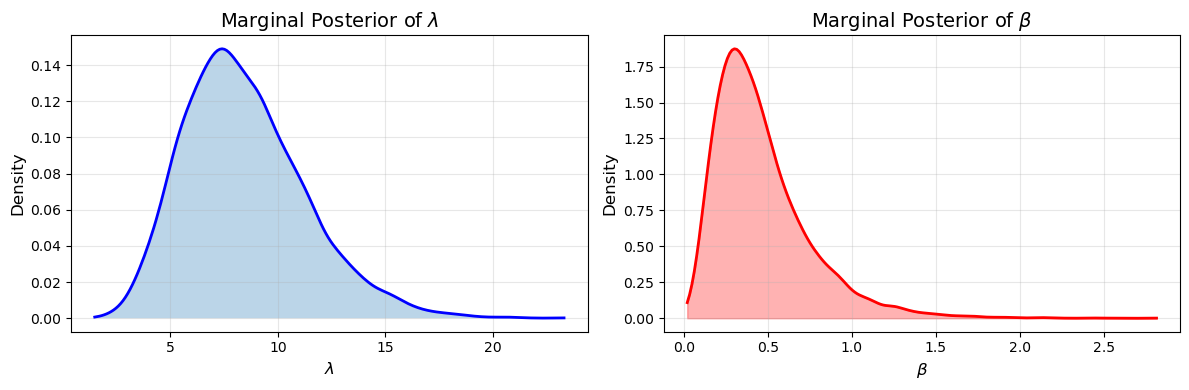


Chosen values: Y = 10, a = 2, b = 1
Lambda:  Posterior Mean: 8.4551
95% Credible Interval: [3.8920, 14.9486]
Beta:  Posterior Mean: 0.4647
95% Credible Interval: [0.1098, 1.1898]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Set random seed for reproducibility
np.random.seed(42)

# Choose observed data Y and hyperparameters (a, b)
Y = 10  # Observed count data
a = 2   # Hyperparameter for beta prior
b = 1   # Hyperparameter for beta prior

# Gibbs sampler parameters
M = 10000  # Total iterations
burn_in = 1000  # Burn-in period

# Storage for samples
lambda_samples = np.zeros(M)
beta_samples = np.zeros(M)

# Initialize
lambda_samples[0] = 1.0
beta_samples[0] = 1.0

# Gibbs sampler
for m in range(1, M):
    # Step 1: Sample lambda from Gamma(Y + 2, 1 + beta)
    shape_lambda = Y + 2
    rate_lambda = 1 + beta_samples[m-1]
    lambda_samples[m] = np.random.gamma(shape_lambda, 1/rate_lambda)
    
    # Step 2: Sample beta from Gamma(a + 2, b + lambda)
    shape_beta = a + 2
    rate_beta = b + lambda_samples[m]
    beta_samples[m] = np.random.gamma(shape_beta, 1/rate_beta)

# Remove burn-in
lambda_post = lambda_samples[burn_in:]
beta_post = beta_samples[burn_in:]

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Marginal posterior of lambda
ax1 = axes[0]
kde_lambda = gaussian_kde(lambda_post)
x_lambda = np.linspace(lambda_post.min(), lambda_post.max(), 200)
ax1.plot(x_lambda, kde_lambda(x_lambda), 'b-', linewidth=2)
ax1.fill_between(x_lambda, kde_lambda(x_lambda), alpha=0.3)
ax1.set_xlabel(r'$\lambda$', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title(r'Marginal Posterior of $\lambda$', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Marginal posterior of beta
ax2 = axes[1]
kde_beta = gaussian_kde(beta_post)
x_beta = np.linspace(beta_post.min(), beta_post.max(), 200)
ax2.plot(x_beta, kde_beta(x_beta), 'r-', linewidth=2)
ax2.fill_between(x_beta, kde_beta(x_beta), alpha=0.3, color='red')
ax2.set_xlabel(r'$\beta$', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title(r'Marginal Posterior of $\beta$', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem2b_posteriors.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute posterior mean and 95% credible interval
lambda_mean = np.mean(lambda_post)
lambda_ci = np.percentile(lambda_post, [2.5, 97.5])

beta_mean = np.mean(beta_post)
beta_ci = np.percentile(beta_post, [2.5, 97.5])

# Print results
print(f"\nChosen values: Y = {Y}, a = {a}, b = {b}")
print(f"Lambda:  Posterior Mean: {lambda_mean:.4f}")
print(f"95% Credible Interval: [{lambda_ci[0]:.4f}, {lambda_ci[1]:.4f}]")
print(f"Beta:  Posterior Mean: {beta_mean:.4f}")
print(f"95% Credible Interval: [{beta_ci[0]:.4f}, {beta_ci[1]:.4f}]")

## Problem 3: Stochastic Differential Equation for Stock Price Simulation

Assume that a stock price, say $s_t$, at time $t$ is a smooth function of time. Denote this smooth function as $g(t)$. Suppose that $g(t)$ satisfies the following stochastic differential equation:

$$\frac{d}{dt}g(t) = \mu g(t) + \sigma g(t) \frac{d}{dt}W(t)$$

where both the drift $\mu$ and the volatility $\sigma$ are constants and the noise $W(t)$ is the standard Brownian motion.

Generate and plot a path of $s_t$ on $t \in [0, 1]$ using the following inputs:

**(i)** $s_0 = 0.35$, $\mu = 3$, $\sigma = 0.1$, $\Delta t = 0.05$

**(ii)** $s_0 = 0.5$, $\mu = -2.5$, $\sigma = 0.1$, $\Delta t = 0.1$

For each case, use:
1. Random walk to simulate the Brownian motions
2. Brownian bridge to simulate the Brownian motions

**Required:** 4 plots total

**Your solution:**

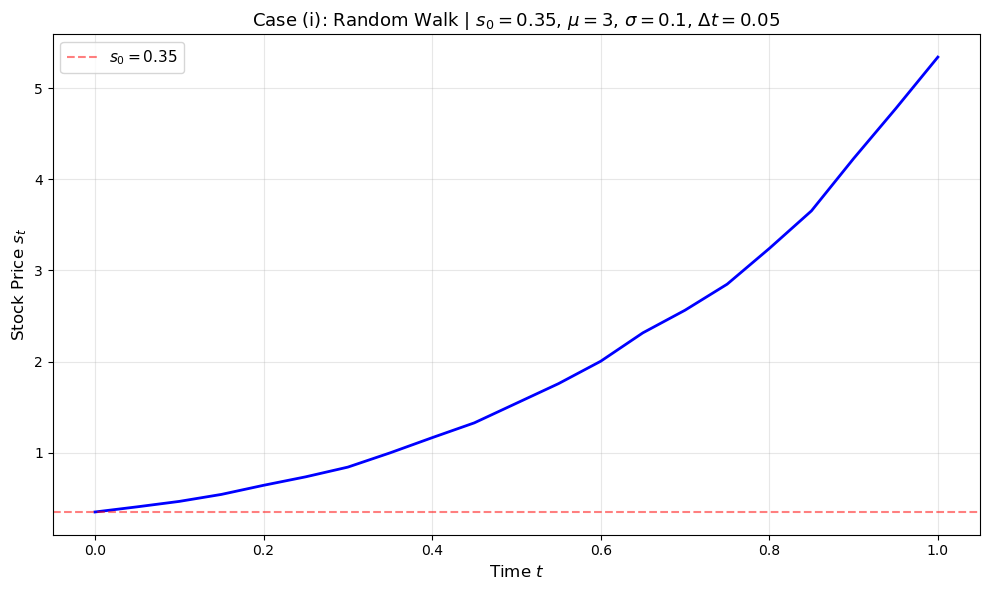

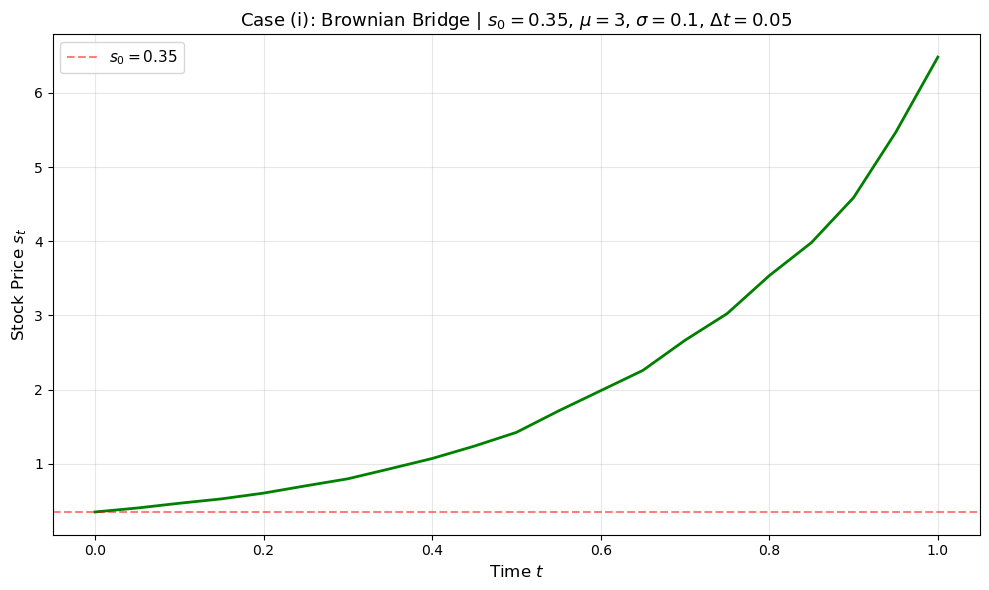

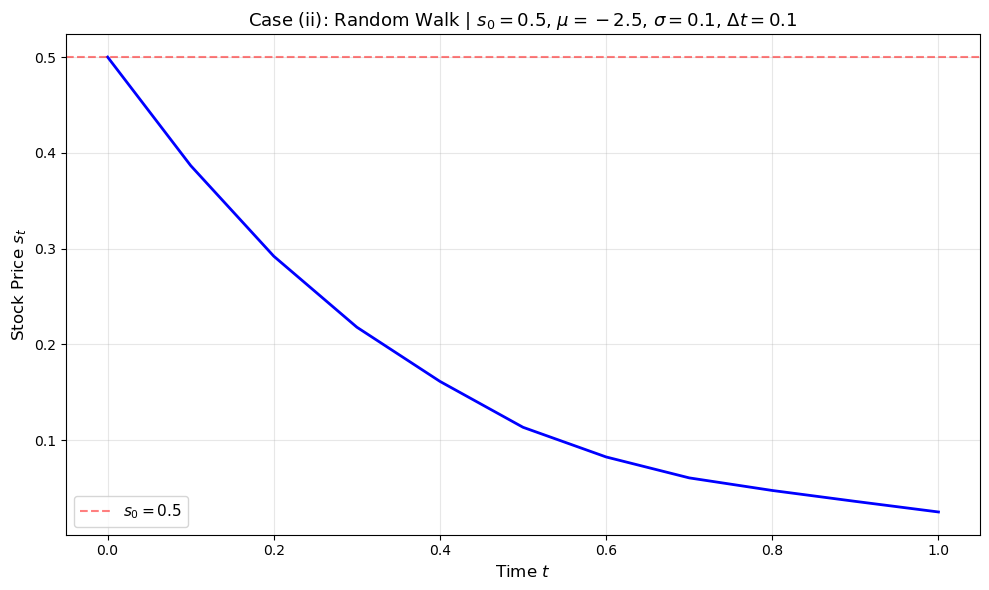

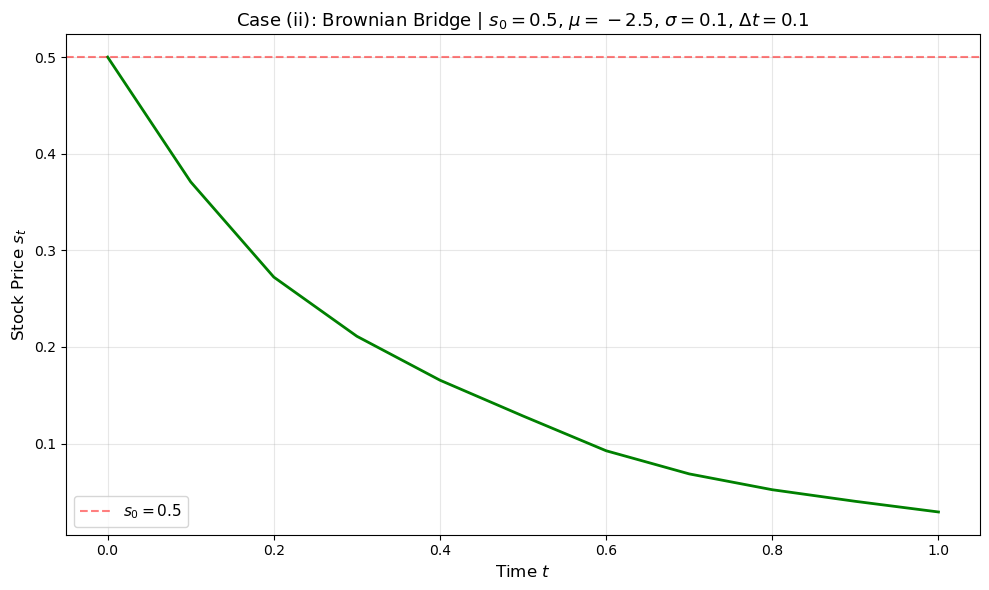


PROBLEM 3: SDE STOCK PRICE SIMULATION - SUMMARY

CASE (i): s₀=0.35, μ=3, σ=0.1, Δt=0.05
  Random Walk:       s(0)=0.3500, s(1)=5.3407
  Brownian Bridge:   s(0)=0.3500, s(1)=6.4837

CASE (ii): s₀=0.5, μ=-2.5, σ=0.1, Δt=0.1
  Random Walk:       s(0)=0.5000, s(1)=0.0251
  Brownian Bridge:   s(0)=0.5000, s(1)=0.0293



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ========== HELPER FUNCTIONS ==========

def simulate_gbm_random_walk(s0, mu, sigma, T, dt):
    """
    Simulate GBM using random walk for Brownian motion.
    ds = mu*s*dt + sigma*s*dW
    dW = sqrt(dt) * Z, where Z ~ N(0,1)
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps + 1)
    s = np.zeros(n_steps + 1)
    s[0] = s0
    
    for i in range(n_steps):
        Z = np.random.randn()
        dW = np.sqrt(dt) * Z
        s[i+1] = s[i] + mu * s[i] * dt + sigma * s[i] * dW
    
    return t, s


def simulate_gbm_brownian_bridge(s0, mu, sigma, T, dt):
    """
    Simulate GBM using Brownian bridge for Brownian motion.
    
    First, generate W(T) ~ N(0, T).
    Then, for each t_i, sample W(t_i) given W(0)=0 and W(T):
    W(t_i) ~ N( (t_i/T)*W(T), t_i*(T-t_i)/T )
    
    Finally, update s using the SDE.
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps + 1)
    
    # Generate Brownian bridge
    W = np.zeros(n_steps + 1)
    W[0] = 0
    WT = np.sqrt(T) * np.random.randn()  # W(T) ~ N(0, T)
    
    # Sample intermediate points using Brownian bridge
    for i in range(1, n_steps):  # Note: not n_steps + 1
        ti = t[i]
        t_prev = t[i-1]
        # Condition on W(t_{i-1}) and W(T)
        tau = (ti - t_prev) / (T - t_prev)
        mean_W = W[i-1] + tau * (WT - W[i-1])
        var_W = (ti - t_prev) * (T - ti) / (T - t_prev)
        W[i] = mean_W + np.sqrt(var_W) * np.random.randn()
    W[-1] = WT  # Ensure W(T) = WT

    
    # Compute stock price from Brownian motion path
    s = np.zeros(n_steps + 1)
    s[0] = s0
    for i in range(n_steps):
        dW = W[i+1] - W[i]
        s[i+1] = s[i] + mu * s[i] * dt + sigma * s[i] * dW
    
    return t, s


# ========== PARAMETERS ==========
np.random.seed(42)

# Case (i): s0=0.35, mu=3, sigma=0.1, dt=0.05
s0_i = 0.35
mu_i = 3
sigma_i = 0.1
dt_i = 0.05
T = 1.0

# Case (ii): s0=0.5, mu=-2.5, sigma=0.1, dt=0.1
s0_ii = 0.5
mu_ii = -2.5
sigma_ii = 0.1
dt_ii = 0.1

# ========== PLOT 1: CASE (i) - RANDOM WALK ==========
t1, s1 = simulate_gbm_random_walk(s0_i, mu_i, sigma_i, T, dt_i)

plt.figure(figsize=(10, 6))
plt.plot(t1, s1, 'b-', linewidth=2)
plt.axhline(s0_i, color='red', linestyle='--', alpha=0.5, label=f'$s_0={s0_i}$')
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Stock Price $s_t$', fontsize=12)
plt.title(f'Case (i): Random Walk | $s_0={s0_i}$, $\mu={mu_i}$, $\sigma={sigma_i}$, $\Delta t={dt_i}$', 
          fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('problem3_case_i_random_walk.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== PLOT 2: CASE (i) - BROWNIAN BRIDGE ==========
t2, s2 = simulate_gbm_brownian_bridge(s0_i, mu_i, sigma_i, T, dt_i)

plt.figure(figsize=(10, 6))
plt.plot(t2, s2, 'g-', linewidth=2)
plt.axhline(s0_i, color='red', linestyle='--', alpha=0.5, label=f'$s_0={s0_i}$')
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Stock Price $s_t$', fontsize=12)
plt.title(f'Case (i): Brownian Bridge | $s_0={s0_i}$, $\mu={mu_i}$, $\sigma={sigma_i}$, $\Delta t={dt_i}$', 
          fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('problem3_case_i_brownian_bridge.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== PLOT 3: CASE (ii) - RANDOM WALK ==========
t3, s3 = simulate_gbm_random_walk(s0_ii, mu_ii, sigma_ii, T, dt_ii)

plt.figure(figsize=(10, 6))
plt.plot(t3, s3, 'b-', linewidth=2)
plt.axhline(s0_ii, color='red', linestyle='--', alpha=0.5, label=f'$s_0={s0_ii}$')
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Stock Price $s_t$', fontsize=12)
plt.title(f'Case (ii): Random Walk | $s_0={s0_ii}$, $\mu={mu_ii}$, $\sigma={sigma_ii}$, $\Delta t={dt_ii}$', 
          fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('problem3_case_ii_random_walk.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== PLOT 4: CASE (ii) - BROWNIAN BRIDGE ==========
t4, s4 = simulate_gbm_brownian_bridge(s0_ii, mu_ii, sigma_ii, T, dt_ii)

plt.figure(figsize=(10, 6))
plt.plot(t4, s4, 'g-', linewidth=2)
plt.axhline(s0_ii, color='red', linestyle='--', alpha=0.5, label=f'$s_0={s0_ii}$')
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Stock Price $s_t$', fontsize=12)
plt.title(f'Case (ii): Brownian Bridge | $s_0={s0_ii}$, $\mu={mu_ii}$, $\sigma={sigma_ii}$, $\Delta t={dt_ii}$', 
          fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('problem3_case_ii_brownian_bridge.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== SUMMARY STATISTICS ==========

print("PROBLEM 3: SDE STOCK PRICE SIMULATION - SUMMARY")

print("\nCASE (i): s₀=0.35, μ=3, σ=0.1, Δt=0.05")
print(f"  Random Walk:       s(0)={s1[0]:.4f}, s(1)={s1[-1]:.4f}")
print(f"  Brownian Bridge:   s(0)={s2[0]:.4f}, s(1)={s2[-1]:.4f}")

print("\nCASE (ii): s₀=0.5, μ=-2.5, σ=0.1, Δt=0.1")
print(f"  Random Walk:       s(0)={s3[0]:.4f}, s(1)={s3[-1]:.4f}")
print(f"  Brownian Bridge:   s(0)={s4[0]:.4f}, s(1)={s4[-1]:.4f}")

print("\n" + "="*70)


## Problem 4: Spread Option Pricing with Monte Carlo

Suppose $S_1$ and $S_2$ are prices of two stocks and follow a correlated GBM$(\mu, \Sigma)$ process under the risk-neutral measure, where:

$$\mu = \begin{pmatrix} r \\ r \end{pmatrix}, \quad \Sigma = \begin{pmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2 & \sigma_2^2 \end{pmatrix}$$

A spread option has payoff $(|S_1(T) - S_2(T)| - K)^+$ at time $T$. Use the Monte Carlo method to get the option price with $N = 5000$ simulations.

**Parameters:**
- $\sigma_1 = 0.04$
- $\sigma_2 = 0.06$
- $\rho = 0.6$
- $S_1(0) = 35$
- $S_2(0) = 33$
- Risk-free rate $r = 0.05$
- Strike price $K = 4$
- Time to maturity $T = 4$
- Time step $dt = 1$

**Your solution:**

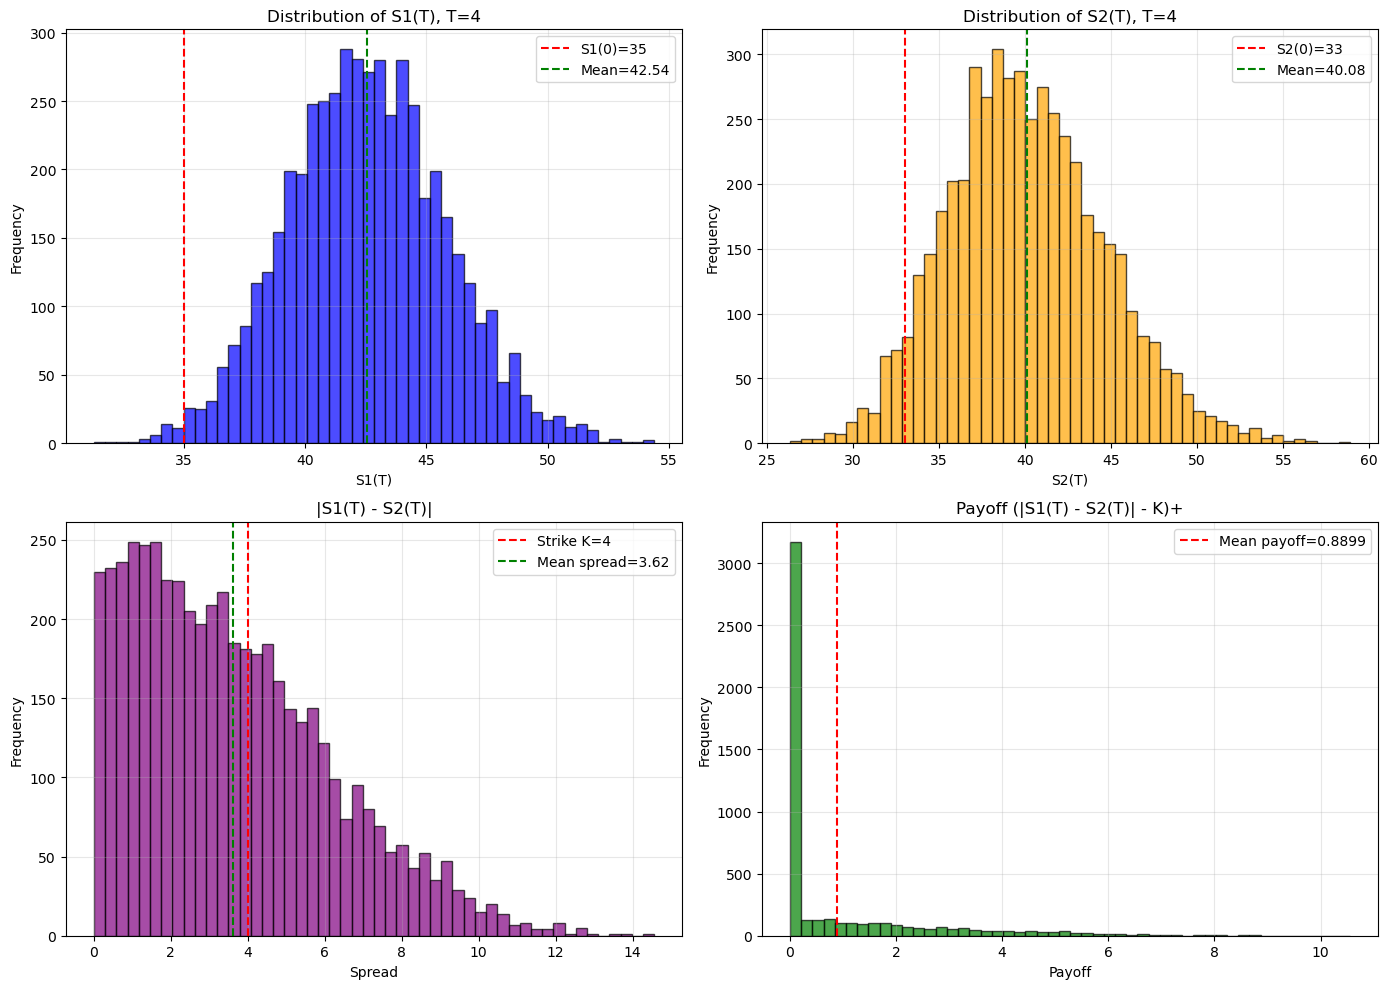

PROBLEM 4: SPREAD OPTION PRICING - MONTE CARLO RESULTS (CORRECTED)

Parameters:
  σ₁ = 0.04
  σ₂ = 0.06
  ρ = 0.6
  S₁(0) = 35
  S₂(0) = 33
  r = 0.05
  K = 4
  T = 4
  dt = 1.0
  N = 5000

Final Stock Price Statistics:
  S₁(T): Mean = 42.5373, Std = 3.2421
  S₂(T): Mean = 40.0759, Std = 4.5519
  Empirical Correlation: 0.5949

Spread and Payoff Statistics:
  Mean spread = 3.6217
  Mean payoff (undiscounted) = 0.8899
  % ITM = 39.18%

SPREAD OPTION PRICE:
  Price = 0.7286
  Std. error = 0.0184
  95% CI = [0.6924, 0.7647]



In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- PARAMETERS ----------
np.random.seed(42)

sigma1 = 0.04
sigma2 = 0.06
rho    = 0.6
S1_0   = 35
S2_0   = 33
r      = 0.05
K      = 4
T      = 4
dt     = 1.0
N      = 5000  # number of Monte Carlo paths

n_steps = int(T / dt)

# ---------- STORAGE ----------
S1_final = np.zeros(N)
S2_final = np.zeros(N)

# ---------- CORRELATED BROWNIAN INCREMENTS ----------
# Use CORRELATION matrix (unit variances), not covariance
corr_matrix = np.array([[1.0, rho],
                        [rho, 1.0]])
L = np.linalg.cholesky(corr_matrix)

# ---------- MONTE CARLO SIMULATION ----------
for sim in range(N):
    S1 = S1_0
    S2 = S2_0

    for _ in range(n_steps):
        # independent standard normals
        Z = np.random.randn(2)

        # correlated standard normals
        Z_corr = L @ Z

        # Brownian increments with correct volatility scaling
        dW1 = sigma1 * np.sqrt(dt) * Z_corr[0]
        dW2 = sigma2 * np.sqrt(dt) * Z_corr[1]

        # Euler–Maruyama update under risk‑neutral measure
        S1 = S1 + r * S1 * dt + S1 * dW1
        S2 = S2 + r * S2 * dt + S2 * dW2

    S1_final[sim] = S1
    S2_final[sim] = S2

# ---------- PAYOFFS & PRICING ----------
spreads = np.abs(S1_final - S2_final)
payoffs = np.maximum(spreads - K, 0.0)

discount_factor = np.exp(-r * T)
option_price = discount_factor * np.mean(payoffs)

std_error = discount_factor * np.std(payoffs, ddof=1) / np.sqrt(N)
ci_low  = option_price - 1.96 * std_error
ci_high = option_price + 1.96 * std_error

# ---------- PLOTS ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# S1(T)
ax = axes[0, 0]
ax.hist(S1_final, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax.axvline(S1_0, color='red', linestyle='--', label=f'S1(0)={S1_0}')
ax.axvline(S1_final.mean(), color='green', linestyle='--',
           label=f'Mean={S1_final.mean():.2f}')
ax.set_title(f'Distribution of S1(T), T={T}')
ax.set_xlabel('S1(T)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

# S2(T)
ax = axes[0, 1]
ax.hist(S2_final, bins=50, color='orange', alpha=0.7, edgecolor='black')
ax.axvline(S2_0, color='red', linestyle='--', label=f'S2(0)={S2_0}')
ax.axvline(S2_final.mean(), color='green', linestyle='--',
           label=f'Mean={S2_final.mean():.2f}')
ax.set_title(f'Distribution of S2(T), T={T}')
ax.set_xlabel('S2(T)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

# spreads
ax = axes[1, 0]
ax.hist(spreads, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(K, color='red', linestyle='--', label=f'Strike K={K}')
ax.axvline(spreads.mean(), color='green', linestyle='--',
           label=f'Mean spread={spreads.mean():.2f}')
ax.set_title('|S1(T) - S2(T)|')
ax.set_xlabel('Spread')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

# payoffs
ax = axes[1, 1]
ax.hist(payoffs, bins=50, color='green', alpha=0.7, edgecolor='black')
ax.axvline(payoffs.mean(), color='red', linestyle='--',
           label=f'Mean payoff={payoffs.mean():.4f}')
ax.set_title('Payoff (|S1(T) - S2(T)| - K)+')
ax.set_xlabel('Payoff')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- TEXT OUTPUT ----------
print("PROBLEM 4: SPREAD OPTION PRICING - MONTE CARLO RESULTS (CORRECTED)")

print("\nParameters:")
print(f"  σ₁ = {sigma1}")
print(f"  σ₂ = {sigma2}")
print(f"  ρ = {rho}")
print(f"  S₁(0) = {S1_0}")
print(f"  S₂(0) = {S2_0}")
print(f"  r = {r}")
print(f"  K = {K}")
print(f"  T = {T}")
print(f"  dt = {dt}")
print(f"  N = {N}")

print("\nFinal Stock Price Statistics:")
print(f"  S₁(T): Mean = {S1_final.mean():.4f}, Std = {S1_final.std(ddof=1):.4f}")
print(f"  S₂(T): Mean = {S2_final.mean():.4f}, Std = {S2_final.std(ddof=1):.4f}")
print(f"  Empirical Correlation: {np.corrcoef(S1_final, S2_final)[0, 1]:.4f}")

print("\nSpread and Payoff Statistics:")
print(f"  Mean spread = {spreads.mean():.4f}")
print(f"  Mean payoff (undiscounted) = {payoffs.mean():.4f}")
print(f"  % ITM = {100 * (payoffs > 0).mean():.2f}%")

print("\nSPREAD OPTION PRICE:")
print(f"  Price = {option_price:.4f}")
print(f"  Std. error = {std_error:.4f}")
print(f"  95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
print("="*70 + "\n")
